## Prediction stock prices
Adapted from:
https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch

In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import os


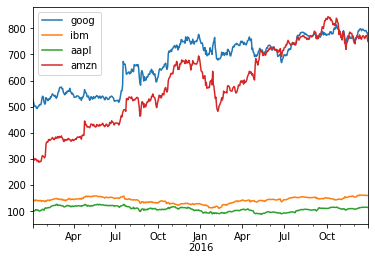

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("dataset/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl', 'amzn']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
#print(df)
df.interpolate().plot()
plt.show()

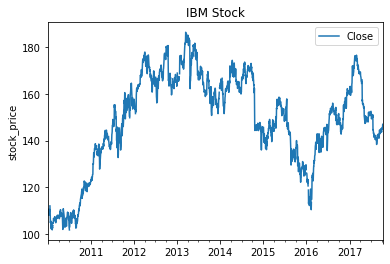

In [3]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("dataset/Data/Stocks/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot()
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [4]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
Close    1958 non-null float64
dtypes: float64(1)
memory usage: 111.7 KB


In [5]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
#df_ibm

In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 20 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

C:\Users\jetma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


x_train.shape =  (1606, 19, 1)
y_train.shape =  (1606, 1)
x_test.shape =  (402, 19, 1)
y_test.shape =  (402, 1)


In [7]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [8]:
y_train.size(),x_train.size()

(torch.Size([1606, 1]), torch.Size([1606, 19, 1]))

In [9]:
n_steps = look_back-1
batch_size = 1606
#n_iters = 3000
num_epochs = 1000 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [10]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
from opti import SAdam, Signum

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
torch.manual_seed(42)    

model1 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model3 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model4 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model5 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model6 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimisers = {'SGD':torch.optim.SGD(model1.parameters(), lr=0.01),
              'Adam':torch.optim.Adam(model2.parameters(), lr=0.01),
              'Adagrad':torch.optim.Adagrad(model3.parameters(), lr=0.01),
              'RMSprop':torch.optim.RMSprop(model4.parameters(), lr=0.01),
              'SAdam':SAdam(model5.parameters(), lr=0.01),
              'Signum':Signum(model6.parameters(), lr=0.01)}

C:\Users\jetma\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [11]:
# Train model
#####################

hists = [np.zeros(num_epochs) for i in range(len(optimisers))]

# Number of steps to unroll
seq_dim =look_back-1

def train(model, i, optimiser, hists):
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)
        if t % 100 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hists[i][t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    return y_train_pred

In [12]:
y_train_pred1 = train(model1, 0, optimisers['SGD'], hists)

Epoch  100 MSE:  0.2614903748035431
Epoch  200 MSE:  0.2520737648010254
Epoch  300 MSE:  0.23997752368450165
Epoch  400 MSE:  0.2225392460823059
Epoch  500 MSE:  0.19519869983196259
Epoch  600 MSE:  0.1507006585597992
Epoch  700 MSE:  0.08555388450622559
Epoch  800 MSE:  0.02784157358109951
Epoch  900 MSE:  0.009123413823544979


In [13]:
y_train_pred2 = train(model2, 1, optimisers['Adam'], hists)

Epoch  100 MSE:  0.0034122993238270283
Epoch  200 MSE:  0.0021501267328858376
Epoch  300 MSE:  0.0017957434756681323
Epoch  400 MSE:  0.0017192329978570342
Epoch  500 MSE:  0.0017188701312988997
Epoch  600 MSE:  0.0017129890620708466
Epoch  700 MSE:  0.0017112265340983868
Epoch  800 MSE:  0.001709736417979002
Epoch  900 MSE:  0.0017240013694390655


In [14]:
y_train_pred3 = train(model3, 2, optimisers['Adagrad'], hists)

Epoch  100 MSE:  0.007329041138291359
Epoch  200 MSE:  0.006256218068301678
Epoch  300 MSE:  0.005519900005310774
Epoch  400 MSE:  0.004914105404168367
Epoch  500 MSE:  0.004432134795933962
Epoch  600 MSE:  0.004086094442754984
Epoch  700 MSE:  0.00404793256893754
Epoch  800 MSE:  0.003560212906450033
Epoch  900 MSE:  0.003346202662214637


In [15]:
y_train_pred4 = train(model4, 3, optimisers['RMSprop'], hists)

Epoch  100 MSE:  0.004942044150084257
Epoch  200 MSE:  0.004521818365901709
Epoch  300 MSE:  0.0037118059117347
Epoch  400 MSE:  0.002441985532641411
Epoch  500 MSE:  0.003216867335140705
Epoch  600 MSE:  0.0034791603684425354
Epoch  700 MSE:  0.0030500045977532864
Epoch  800 MSE:  0.014250942505896091
Epoch  900 MSE:  0.0024813769850879908


In [16]:
y_train_pred5 = train(model5, 4, optimisers['SAdam'], hists)

Epoch  100 MSE:  8.599325180053711
Epoch  200 MSE:  9.06482982635498
Epoch  300 MSE:  8.93847370147705
Epoch  400 MSE:  8.516780853271484
Epoch  500 MSE:  8.422253608703613
Epoch  600 MSE:  8.491875648498535
Epoch  700 MSE:  8.33340835571289
Epoch  800 MSE:  8.296510696411133
Epoch  900 MSE:  8.266843795776367


In [17]:
y_train_pred6 = train(model6, 5, optimisers['Signum'], hists)

Epoch  100 MSE:  0.01757865771651268
Epoch  200 MSE:  0.012953796423971653
Epoch  300 MSE:  0.01613045111298561
Epoch  400 MSE:  0.01192327681928873
Epoch  500 MSE:  0.008552677929401398
Epoch  600 MSE:  0.0053347814828157425
Epoch  700 MSE:  0.005497600883245468
Epoch  800 MSE:  0.004978370852768421
Epoch  900 MSE:  0.0058866823092103004


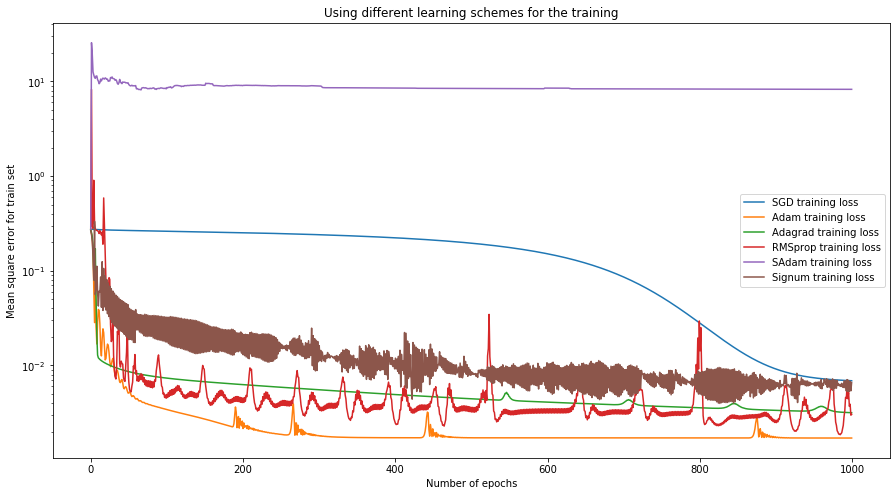

In [18]:
plt.figure(figsize=(15,8))
plt.plot(hists[0], label="SGD training loss")
plt.plot(hists[1], label="Adam training loss")
plt.plot(hists[2], label="Adagrad training loss")
plt.plot(hists[3], label="RMSprop training loss")
plt.plot(hists[4], label="SAdam training loss")
plt.plot(hists[5], label="Signum training loss")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Mean square error for train set")
plt.title("Using different learning schemes for the training")
plt.yscale('log')
plt.savefig('learning_loss.png')
plt.show()

### Analysis


In [19]:
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#### SGD

In [20]:
# make predictions
y_test_pred1 = model1(x_test)

# invert predictions
y_train_pred1 = scaler.inverse_transform(y_train_pred1.detach().numpy())
y_test_pred1 = scaler.inverse_transform(y_test_pred1.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred1[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.51 RMSE
Test Score: 2.64 RMSE


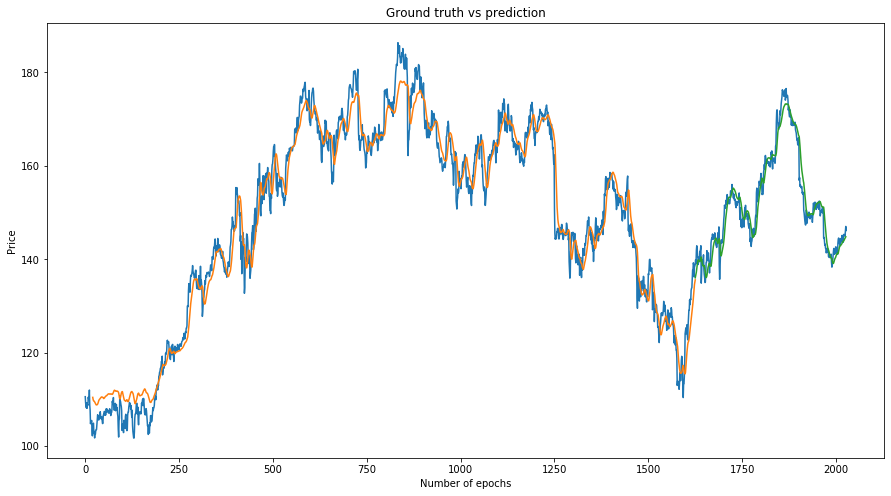

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred1

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred1

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### Adam

In [22]:
# make predictions
y_test_pred2 = model2(x_test)

# invert predictions
y_train_pred2 = scaler.inverse_transform(y_train_pred2.detach().numpy())
y_test_pred2 = scaler.inverse_transform(y_test_pred2.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred2[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred2[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.75 RMSE
Test Score: 1.44 RMSE


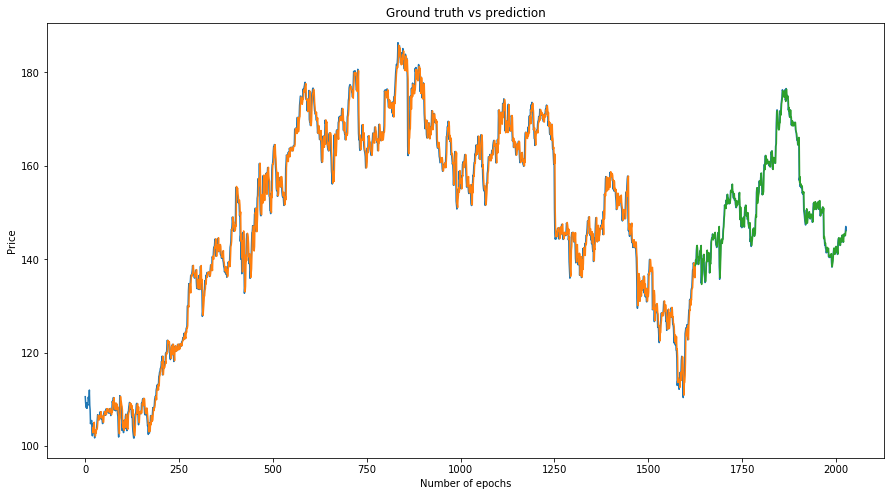

In [23]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred2

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred2

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### Adagrad

In [24]:
# make predictions
y_test_pred3 = model3(x_test)

# invert predictions
y_train_pred3 = scaler.inverse_transform(y_train_pred3.detach().numpy())
y_test_pred3 = scaler.inverse_transform(y_test_pred3.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred3[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred3[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.38 RMSE
Test Score: 1.88 RMSE


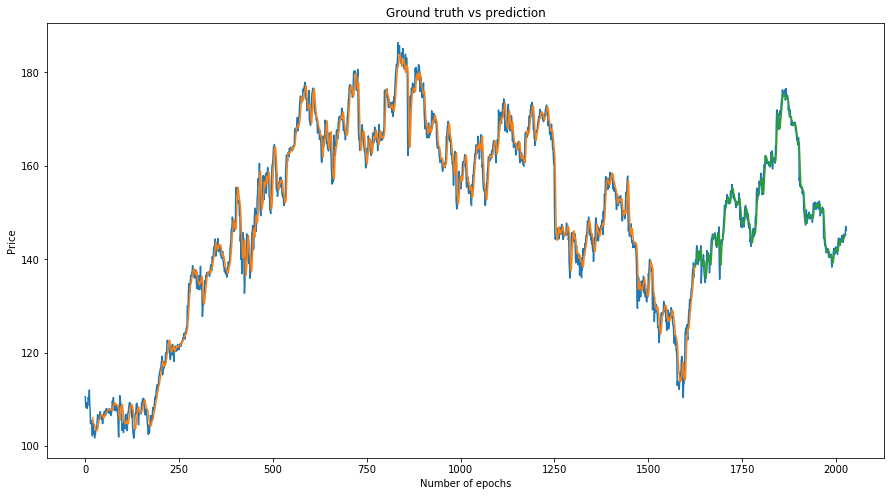

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred3

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred3

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### RMSprop

In [26]:
# make predictions
y_test_pred4 = model4(x_test)

# invert predictions
y_train_pred4 = scaler.inverse_transform(y_train_pred4.detach().numpy())
y_test_pred4 = scaler.inverse_transform(y_test_pred4.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred4[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred4[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.33 RMSE
Test Score: 1.63 RMSE


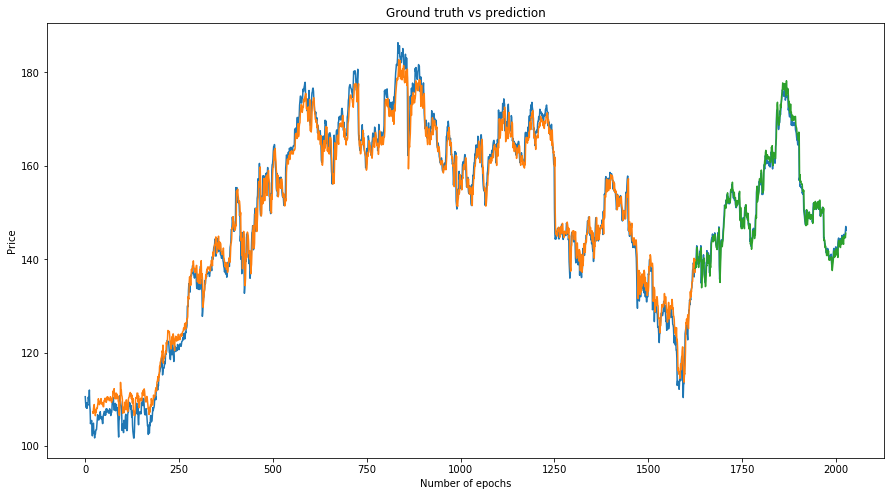

In [27]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred4

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred4

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### SAdam

In [28]:
# make predictions
y_test_pred5 = model5(x_test)

# invert predictions
y_train_pred5 = scaler.inverse_transform(y_train_pred5.detach().numpy())
y_test_pred5 = scaler.inverse_transform(y_test_pred5.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred5[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred5[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 121.48 RMSE
Test Score: 146.63 RMSE


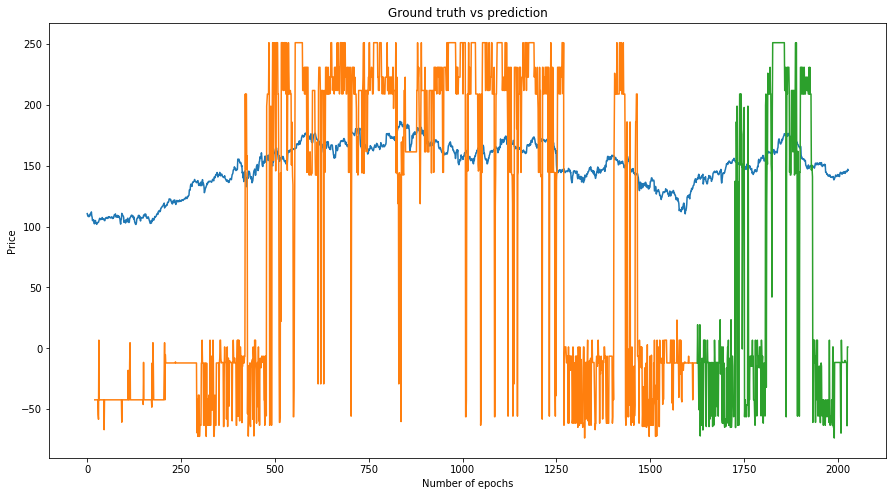

In [29]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred5

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred5

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### Signum

In [30]:
# make predictions
y_test_pred6 = model6(x_test)

# invert predictions
y_train_pred6 = scaler.inverse_transform(y_train_pred6.detach().numpy())
y_test_pred6 = scaler.inverse_transform(y_test_pred6.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred6[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred6[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.44 RMSE
Test Score: 3.04 RMSE


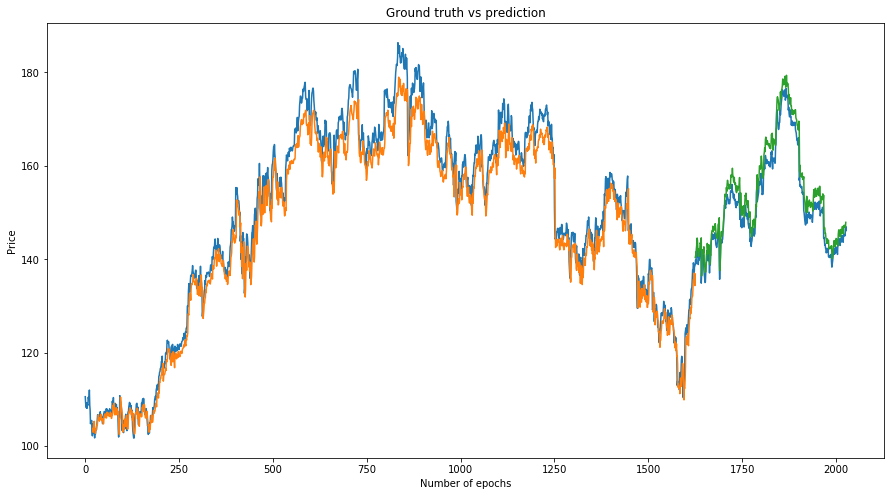

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_ibm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred1)+look_back, :] = y_train_pred6

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_ibm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred1)+look_back-1:len(df_ibm)-1, :] = y_test_pred6

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df_ibm))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Number of epochs")
plt.ylabel("Price")
plt.title("Ground truth vs prediction")
plt.show()

#### Numbers of parameters

In [33]:
model_parameters = filter(lambda p: p.requires_grad, model1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

12961